# Keras 개발 Process

1. 입력 텐서(X)와 출력 텐서(y)로 이뤄진 **훈련 데이터를 정의**

2. 입력과 출력을 연결하는 Layer(층)으로 이뤄진 **네트워크(모델)을 정의**
    - Sequential 방식: 순서대로 쌓아올린 네트워크로 이뤄진 모델을 생성하는 방식
    - Functional API 방식: 다양한 구조의 네트워크로 이뤄진 모델을 생성하는 방식
    - Subclass 방식: 네트워크를 정의하는 클래스를 구현.
    

3. **모델 Compile(컴파일)**
    - 모델이 Train(학습)할때 사용할 손실함수(Loss Function), 최적화기법(Optimizer), 학습과정을 모니터링할 평가지표(Metrics)를 설정
    
    > Compile: 실행할 수 있는 상태로 만들어 주는 것.

4. **Training(학습/훈련)**
    - Train dataset을 이용해 모델을 Train 시킨다.

# MNIST 이미지 분류 
- ### [MNIST](https://ko.wikipedia.org/wiki/MNIST_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B2%A0%EC%9D%B4%EC%8A%A4)(Modified National Institute of Standards and Technology) database
- 흑백 손글씨 숫자 0-9까지 10개의 범주로 구분해놓은 데이터셋
- 하나의 이미지는 28 * 28 pixel 의 크기
- 6만개의 Train 이미지와 1만개의 Test 이미지로 구성됨.

##### import

In [1]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras

print(tf.__version__) # 설치된 tensorflow 버전 확인. -> 라이브러리의 버전이 몇인지 나온다.
# seed값 설정
# sikict- learn은 randomstate=0이라고 설정을 할 수 있었는데 tensorflow는 없어서 밑에 처럼 random,seed를 설정해줘야한다.
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

2.13.0


##### MNIST dataset Loading

In [2]:
# 데이터 로드 및 분류
(train_image, train_label), (test_image, test_label) = keras.datasets.mnist.load_data()

In [3]:
train_image.shape, train_label.shape, test_image.shape, test_label.shape
# (60000: 개수, (28, 28): 한개의 데이터의 shape) => 28행 28열로 데이터가 총 60000개야
# 이미지 데이터가 2차원인 경우 (gray scale) - (height,width)
# 이미지 데이터가 3차원인 경우 (color) - (height, width, channel:한 pixel의 값을 구성하는 값들 R,G,B)

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
# 숫자 확인 해보기 - 안써도됨
train_image[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

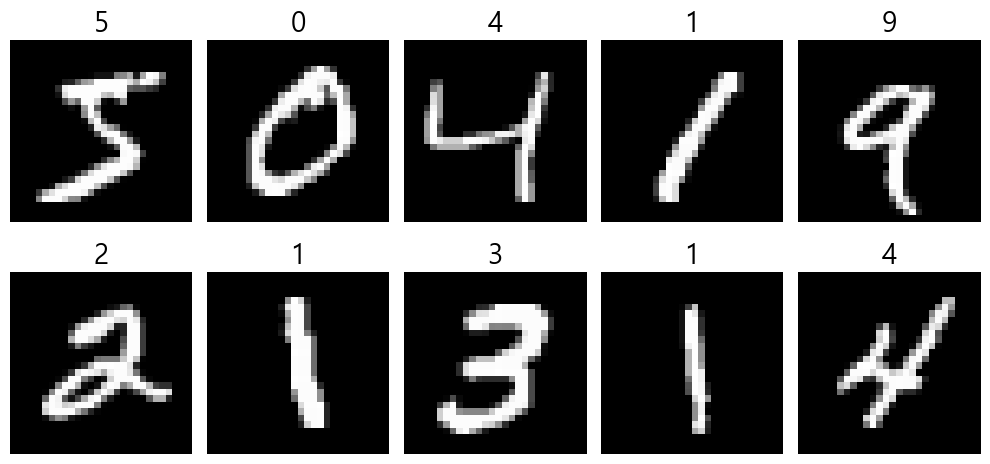

In [5]:
# X값-image 확인
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5)) 

for i in range(10): # 10개 이미지 출력
    plt.subplot(2, 5, i+1) # figure를 2X5으로 나눔.
    plt.imshow(train_image[i], cmap='gray') # 최소값: black 최대값: white
    # 0에 가까우면 검은색에 가까운회색 큰값이면 화이트에 가까워진다.
    plt.title(f'{train_label[i]}', fontsize=20) # 정답
    plt.axis('off') # spine(외곽의 경계선 |_ )들을 제거

plt.tight_layout() # 배치를 알아서 잘 해줘
plt.show()
# 60000개 중에 10개만 본 것이다. 다른것도 보려면 plt.subplot부분을 조정해 주면 된다.

## 데이터 준비
- X (Input Data Image)
    - 0 ~ 1 사이의 값으로 정규화 시킨다.
- y (Output Data)
    - one hot encoding 처리
        - Label이 다중분류(Multi class classification)일 경우 One Hot Encoding 한다.
            - 딥러닝 모델이 각 Label별 확률을 출력하도록 정의 되기 때문에 y(정답)도 같은 형태로 만들어 줘야 한다.
    - Keras의 onehot encoding 처리 함수
        - tensorflow.keras.utils.to_categorical()

##### input image(X)를 정규화. 
- 이미지를 0 ~ 1 로 정규화 하고 타입을 float32로 변환

In [6]:
train_image.min(),train_image.max(), train_image.dtype # uint8: int형 8bit이지만 부호가 필요없어서 n이다.

(0, 255, dtype('uint8'))

In [7]:
# 연속형 전처리
# 딥러닝은 float를 좋아함
# min_max_scaling: 0-255로 정해져있기 때문에 그냥 255로 나누면 된다.
X_train = train_image.astype("float32")/255
X_test = test_image.astype('float32')/255

##### label(y)를 one hot encoding

In [8]:
# 범주형 전처리
np.unique(train_label, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949],
       dtype=int64))

In [9]:
# to_categorical가 one hot encoding처리해준다.
y_train = keras.utils.to_categorical(train_label, num_classes=10) # num_classes=10 생략가능
y_test = keras.utils.to_categorical(test_label)

y_train.shape, y_test.shape

((60000, 10), (10000, 10))

In [10]:
train_label[:2]

array([5, 0], dtype=uint8)

In [11]:
y_train[:2]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

## 네트워크(모델) 정의
- Network : 전체 모델 구조

In [12]:
# Sequential model 정의 2: 모델객체를 생성하고 add() 메소드를 이용해 순서대로 Layer 를 하나씩 추가.
model = keras.Sequential()  # 딥러닝 모델을 생성 -> 빈모델 생성.
# Sequential 모델에 Layer들을 추가
## Layer -> 함수. 이전 Layer의 출력을 입력으로 받아서 처리한 뒤에 그 결과를 출력.

model.add(keras.layers.InputLayer((28, 28))) # InputLayer => Input data shape 지정

model.add(keras.layers.Flatten())  # 다차원 입력을 1차원으로 변환.
# 선형회귀하기위해 1차원으로 변환한것이다.

model.add(keras.layers.Dense(units=256))
# unit/node/neuron 256개로 이루어진 layer를 생성.
# unit -선형회귀 공식1개라고 생각하면된다.(X(입력값)*W(가중치)+B(bias))
model.add(keras.layers.ReLU())
# 활성함수(Activation 함수) Layer를 추가. ReLU: max(x,0)-x랑0비교해서 큰값이 나옴  ==> 비선형함수를 추가.
# 선형회귀만 하면 /이런형식만 되서 비슷한 형식만 나오게 되서
# 데이터의 흐름(특성,입력데이터의 모형)을 바꿔줘서 N 모양으로 한번씩 틀어서 흐름을 바꿔주는것이다.

model.add(keras.layers.Dense(units=128))
model.add(keras.layers.ReLU())
model.add(keras.layers.Dense(units=10))

model.add(keras.layers.Softmax(name='output')) # 출력(output) Layer. 이 Layer의 출력결과가 모델의 출력결과(예측결과)

In [13]:
# 위의 코드처럼 하나하나 add해도 되고 아님 아래 코드처럼 Sequential로 배열(리스트)를 만들어서 넣을 수 도 있다.
# Sequential Model 정의 2: 객체 생성시 Layer들을 순서대로 리스트로 묶어 전달.
# 실행할 것을 순서대로 하는데 이것을 layers라고한다. - 마치 파이프라인같다.
model2 = keras.Sequential([
    keras.layers.InputLayer((28,28)), 
    keras.layers.Flatten(),
    keras.layers.Dense(256),
    keras.layers.ReLU(),
    keras.layers.Dense(units=128),
    keras.layers.ReLU(),
    keras.layers.Dense(10),
    keras.layers.Softmax()
])


In [14]:
# 모델의 구조를 확인
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 re_lu (ReLU)                (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 re_lu_1 (ReLU)              (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
 output (Softmax)            (None, 10)                0

In [15]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               200960    
                                                                 
 re_lu_2 (ReLU)              (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 re_lu_3 (ReLU)              (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
 softmax (Softmax)           (None, 10)               

In [16]:
# !pip install graphviz pydot pydotplus -U
# -U는 패키저매니저에 설치되어있어도 최신버전이 있으면 업그레이드 해라
# 만약 -U가 없다면 설치되어있으면 그냥 설치안하고 최신버전이 있어도 업그레이드 안함
# 설치 후 RESTART

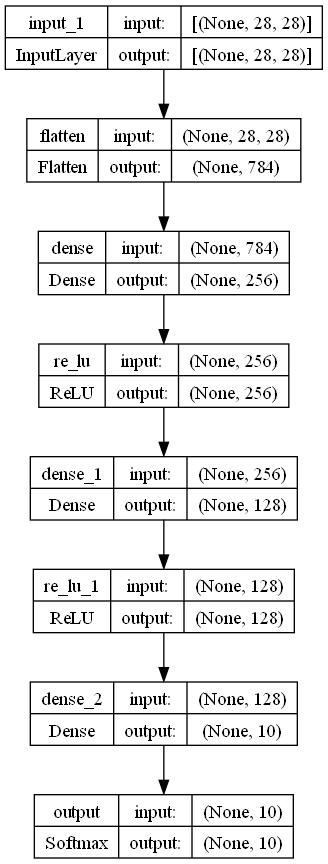

In [32]:
# graphviz를 이용한 모델구조를 시각화 
## 다음 패키지를 설치해야한다.
## pip install graphviz pydot pydotplus
keras.utils.plot_model(model, 
                       show_shapes=True # input, output shape을 같이 출력
                      , to_file='model_shapes.png' # 파일로 저장 (생략: model.png=> 이미 있는 파일이라 덮어씌워지므로)
                      )
# 복잡한 모델을 summary보다 plot으로 보는게 좋다.

## 컴파일 단계
- 정의된 딥러닝 모델을 학습할 수 있는 상태로 만들어 주기 위해 다음을 추가적으로 설정 한다.
    - Optimizer
    - 손실함수
    - 평가지표

In [18]:
model.compile(optimizer='adam', # 최적화 알고리즘 선택
             loss='categorical_crossentropy', # 손실함수 선택(필수로 해줘야한다.)
             metrics=['accuracy'] # 학습 도중/최종평가 때 출력되는 로그(학습기록)에 loss와 함께 같이 볼 추가 평가지표(선택사항)
             )

## 학습 (fit)
- model.fit()
    - 모델 학습 메소드. 
    - 학습과정의 Log를 **History** 객체에 넣어 반환한다.
- **History**: train 시 에폭별 평가지표값들을 모아서 제공. 


In [33]:
# 모델 학습
history = model.fit(X_train, y_train, # Trains dataset
                      epochs=10, # Train dataset을 몇 번 반복해서 학습할지 지정.(오차를 최대한 줄일 수 있을 반복횟수)
                      batch_size=100, # 학습시 한번에 주입하는 데이터 개수.
                                    # 지정한 개수 당 한번씩 parameter를 업데이트 한다.
                                    # 파라미터를 업데이트 하는 단위를 step이라고 한다.
                      validation_split=0.3 # train set을 학습시 다쓰지 않고 70%는학습할 때 쓰고 30%는 검증할때 사용
                                            # 즉 train set 중 검증 데이터로 사용할 비용
                                            # 생략하면 전체를 다 학습에 사용.
                     )

Epoch 1/10
420/420 [==============================] - 1s 3ms/step - loss: 0.0136 - accuracy: 0.9955 - val_loss: 0.1230 - val_accuracy: 0.9723
Epoch 2/10
420/420 [==============================] - 1s 3ms/step - loss: 0.0095 - accuracy: 0.9967 - val_loss: 0.1190 - val_accuracy: 0.9752
Epoch 3/10
420/420 [==============================] - 1s 3ms/step - loss: 0.0128 - accuracy: 0.9956 - val_loss: 0.1186 - val_accuracy: 0.9742
Epoch 4/10
420/420 [==============================] - 1s 3ms/step - loss: 0.0065 - accuracy: 0.9980 - val_loss: 0.1362 - val_accuracy: 0.9733
Epoch 5/10
420/420 [==============================] - 1s 3ms/step - loss: 0.0106 - accuracy: 0.9964 - val_loss: 0.1468 - val_accuracy: 0.9724
Epoch 6/10
420/420 [==============================] - 1s 3ms/step - loss: 0.0078 - accuracy: 0.9975 - val_loss: 0.1181 - val_accuracy: 0.9776
Epoch 7/10
420/420 [==============================] - 1s 3ms/step - loss: 0.0081 - accuracy: 0.9971 - val_loss: 0.1342 - val_accuracy: 0.9750
Epoch 

#### 현재 epoch / 총 epoch
Epoch 10/10
#### 현재 step / 총 step  총학습시간  setp당 걸린시간  trainset검증결과
420/420 [======] -       1s          3ms/step    - loss: 0.0135    - accuracy: 0.9955  
validation 검증결과

-val_loss: 0.1267 - val_accuracy: 0.9719

In [37]:
60000 * 0.7 / 100

420.0

##### History 시각화

In [20]:
print(type(history))
print("학습 에폭리스트: ", history.epoch)
print("에폭수, 에폭당 step수: ", history.params)

<class 'keras.src.callbacks.History'>
학습 에폭리스트:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
에폭수, 에폭당 step수:  {'verbose': 1, 'epochs': 10, 'steps': 420}


In [21]:
history.history # history안에 history속성이 있다. 딕셔너리로서 변화된 값을 에폭별로 알려준다.

{'loss': [0.3009990453720093,
  0.11648231744766235,
  0.07370098680257797,
  0.051031243056058884,
  0.035281840711832047,
  0.02790009044110775,
  0.022139938548207283,
  0.017291372641921043,
  0.014327033422887325,
  0.013533477671444416],
 'accuracy': [0.913023829460144,
  0.9653809666633606,
  0.9780714511871338,
  0.984333336353302,
  0.9889047741889954,
  0.9918333292007446,
  0.9931666851043701,
  0.9946666955947876,
  0.9954761862754822,
  0.9955475926399231],
 'val_loss': [0.1614375114440918,
  0.1220814511179924,
  0.10316690057516098,
  0.09960958361625671,
  0.11194351315498352,
  0.09583226591348648,
  0.09754395484924316,
  0.10916803777217865,
  0.1104227602481842,
  0.12667128443717957],
 'val_accuracy': [0.9531111121177673,
  0.9646111130714417,
  0.9697777628898621,
  0.9712222218513489,
  0.9687222242355347,
  0.9733889102935791,
  0.9745000004768372,
  0.9730555415153503,
  0.9736666679382324,
  0.9718888998031616]}

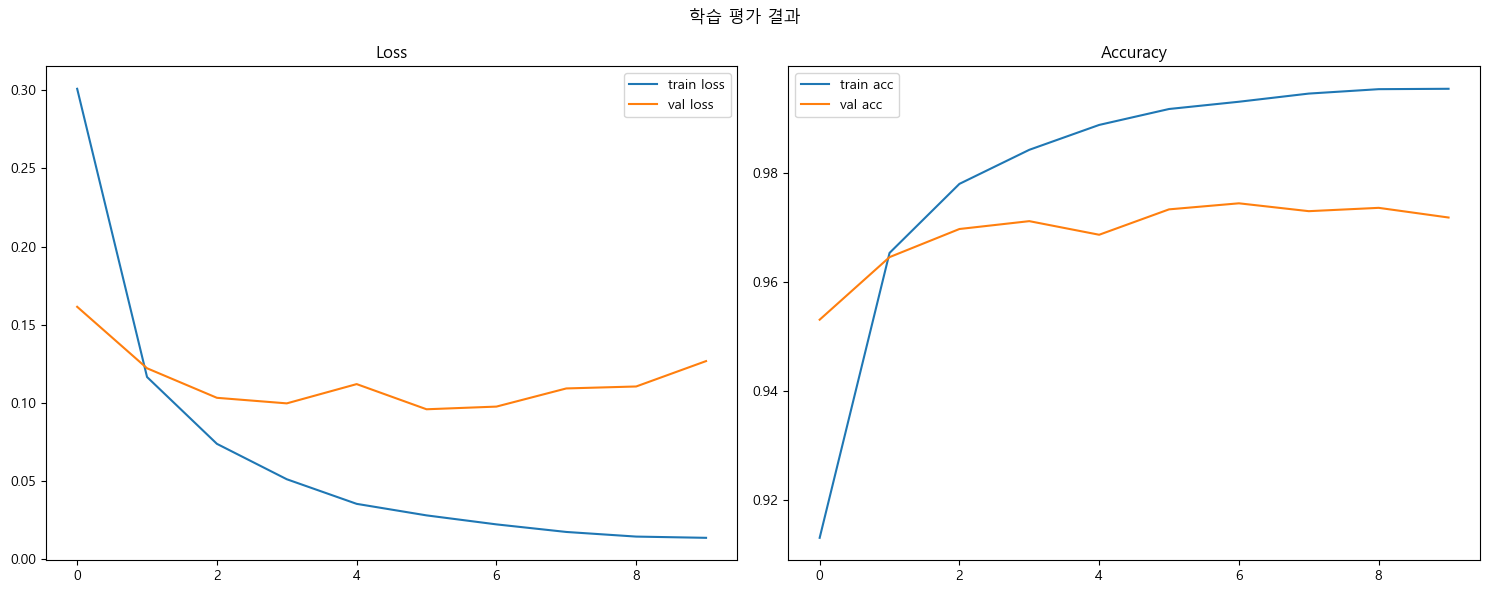

In [22]:
# 학습 에폭별 loss와 accuracy 변화량 시각화
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'malgun gothic'
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(15, 6))
plt.suptitle('학습 평가 결과')

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')

plt.legend()
plt.tight_layout()
plt.show()

## 테스트셋 평가

In [23]:
result = model.evaluate(X_test, y_test) # loss하고 컴파일한것을 자동으로 평가해줌

313/313 [==============================] - 1s 2ms/step - loss: 0.1031 - accuracy: 0.9749


In [24]:
result

[0.10311970114707947, 0.9749000072479248]

## 새로운 데이터 추론
- 새로운 데이터를 추론하기 전에 학습데이터에 했던 전처리과정을 동일하게 적용 한 뒤 추론한다.

### 추론 메소드
- predict()
    - **분류:** 각 클래스 별 확률 반환
    - **회귀:** 최종 예측 결과
- 분류문제일때 predict() 결과에서 class label 출력하기    
    - 이진 분류(binary classification)
        - `numpy.where(model.predict(x) > 0.5, 1, 0).astype("int32")`
    - 다중클래스 분류(multi-class classification)
        - `numpy.argmax(model.predict(x), axis=1)`

In [38]:
X_new = X_test[:3]
X_new.shape

(3, 28, 28)

In [26]:
pred = model.predict(X_new)

1/1 [==============================] - 0s 82ms/step


In [39]:
print(pred.shape)
pred
np.round(pred, 3)

(3, 10)


array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [28]:
np.argmax(pred, axis=1)

array([7, 2, 1], dtype=int64)

In [29]:
np.argmax(y_test[:3], axis=-1)

array([7, 2, 1], dtype=int64)

### 그림판 이미지

In [42]:
### 이미지를 읽어올게 필요하다.
!pip install opencv-contrib-python

                                              0.0/44.8 MB ? eta -:--:--
                                              0.0/44.8 MB ? eta -:--:--
                                             0.0/44.8 MB 640.0 kB/s eta 0:01:10
                                              0.1/44.8 MB 1.2 MB/s eta 0:00:38
     -                                        2.0/44.8 MB 14.5 MB/s eta 0:00:03
     ----                                     4.9/44.8 MB 25.8 MB/s eta 0:00:02
     ------                                   7.8/44.8 MB 33.1 MB/s eta 0:00:02
     ---------                               10.6/44.8 MB 59.5 MB/s eta 0:00:01
     -----------                             13.5/44.8 MB 59.5 MB/s eta 0:00:01
     --------------                          16.2/44.8 MB 59.8 MB/s eta 0:00:01
     ----------------                        19.0/44.8 MB 59.5 MB/s eta 0:00:01
     ------------------                      20.8/44.8 MB 54.7 MB/s eta 0:00:01
     --------------------                    23.1/44.8 MB

In [43]:
import cv2

In [44]:
# 이미지 읽어오기 - imread():ndarray
one = cv2.imread("data/one.png", cv2.IMREAD_GRAYSCALE) # grayscale:흑백으로 읽어오기
five = cv2.imread("data/five.png", cv2.IMREAD_GRAYSCALE)
print(type(one),type(five))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [45]:
one.shape, five.shape

((64, 68), (64, 68))

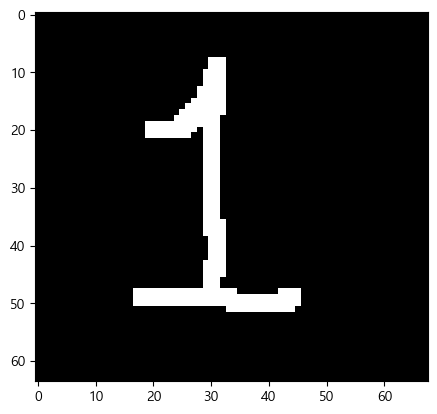

In [47]:
plt.imshow(one, cmap='gray')

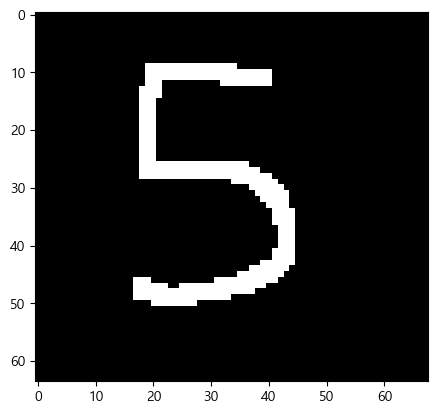

In [49]:
plt.imshow(five, cmap='gray')

In [51]:
# 28*28로 resize
one_input = cv2.resize(one,(28,28))
five_input = cv2.resize(five,(28,28))
one_input.shape, five_input.shape

((28, 28), (28, 28))

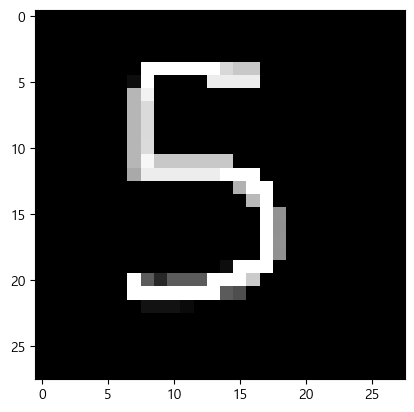

In [53]:
plt.imshow(five_input, cmap='gray')

In [54]:
one_input.min(), one_input.max()

(0, 255)

In [55]:
one_input = one_input.astype("float32")/255
five_input = five_input.astype("float32")/255

In [56]:
input_tensor = np.array([one_input, five_input])
input_tensor

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [57]:
p = model.predict(input_tensor)

1/1 [==============================] - 0s 16ms/step


In [58]:
np.argmax(p, axis=1)

array([2, 5], dtype=int64)